In [1]:
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from core.util.plot_predictions import plot_predictions
from core.util.save_model import save_model, load_parameters
from core.util.get_datasets import get_test_set
from core.util.trefor_dataset import TreforData
from core.models import LSTM
from core.models.model_training import blocked_training, test_model
from core.util.hyperparameter_configuration import get_hyperparameter_configuration
from core.util.metrics import mae, rmse, smape

Set global parameters.

In [2]:
# To be modified depending on gridsearch result
grid_search = load_parameters("00_LSTM_trefor_park")
batch_size = int(grid_search["batch_size"])
learning_rate = grid_search["learning_rate"]
num_layers = int(grid_search["num_layers"])
lookback = int(grid_search["lookback"])

# Extract hyperparameters configuration that will not be tuned upon
(
    hidden_size,
    EPOCHS,
    horizon,
    loss_function,
    dropout_rate,
    folds,
    early_stopper,
) = get_hyperparameter_configuration()
model_input_size = 1

{'learning_rate': 0.001, 'batch_size': 128.0, 'lookback': 96.0, 'num_layers': 2.0}
 Hidden size: 16
 EPOCS: 200
 horizon: 24
 dropout_rate: 0.2
 folds: 9


Use CUDA (GPU) if available.

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

Initialize a very basic LSTM.

In [4]:
def get_model() -> nn.Module:
    """Get the model for training folds."""
    model = LSTM(
        input_size=model_input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout_rate=dropout_rate,
        horizon=horizon,
        lookback=lookback,
    )
    model.to(device)
    return model

Validate the training model on the validation set for each epoch.

In [5]:
for i in range(3):
    early_stopper.reset()
    experiment_name = "00_LSTM_trefor_park_iteration_" + str(i)
    best_train_loss, best_val_loss, best_model = blocked_training(
        model=get_model(),
        learning_rate=learning_rate,
        device=device,
        batch_size=batch_size,
        lookback=lookback,
        early_stopper=early_stopper,
    )

    x_test, y_test = get_test_set(lookback=lookback, horizon=horizon, folds=folds)
    test_dataset = TreforData(x_test, y_test, device)
    testing_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    t_loss, predicted = test_model(
        best_model=best_model,
        loss_function=loss_function,
        testing_loader=testing_loader,
    )

    model_mae = mae(y_test.tolist(), predicted)
    model_rmse = rmse(y_test.tolist(), predicted)
    model_smape = smape(y_test.tolist(), predicted)

    print(experiment_name)
    print(f"MAE: {model_mae}")
    print(f"RMSE: {model_rmse}")
    print(f"SMAPE: {model_smape}")

    save_model(
        model=best_model,
        model_name=experiment_name,
        train_loss=best_train_loss,
        val_loss=best_val_loss,
        mae=model_mae,
        rmse=model_rmse,
        smape=model_smape,
        overwrite=True,
    )

Iterating epochs:   0%|          | 0/200 [00:00<?, ?it/s]

00_LSTM_trefor_park_iteration_0
MAE: 0.07039721310138702
RMSE: 0.11238320431083587
SMAPE: 95.7942123413086


Iterating epochs:   0%|          | 0/200 [00:00<?, ?it/s]

00_LSTM_trefor_park_iteration_1
MAE: 0.06854663044214249
RMSE: 0.10676220279726313
SMAPE: 95.2418441772461


Iterating epochs:   0%|          | 0/200 [00:00<?, ?it/s]

00_LSTM_trefor_park_iteration_2
MAE: 0.06467040628194809
RMSE: 0.09552398264907515
SMAPE: 84.582763671875


## Visualize model performance
Visualize the training and validation loss.

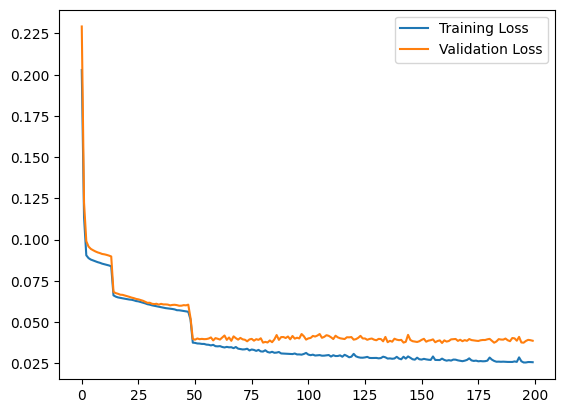

In [6]:
plt.clf()
plt.plot(best_train_loss, label="Training Loss")
plt.plot(best_val_loss, label="Validation Loss")
plt.legend()
plt.show()

### Predictions- and actual consumption

Plot the actual values and predictions from the model on the test set.

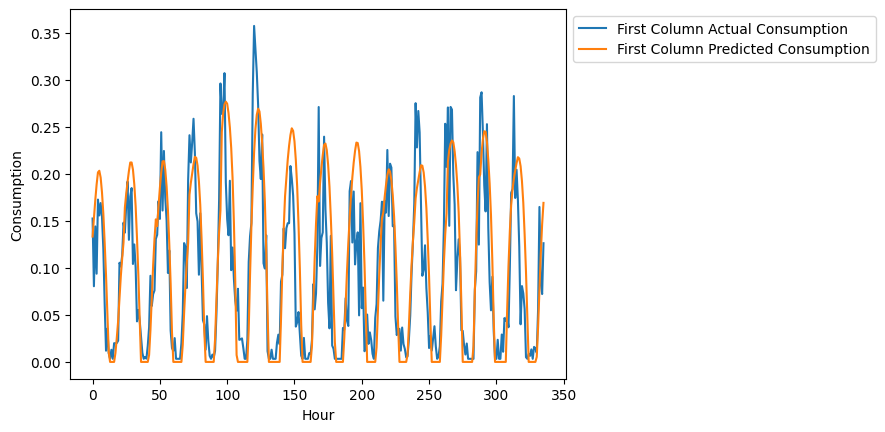

In [7]:
plot_predictions(110, 124, y_test, predicted)

Plot predictions for the first 7 days in the test set

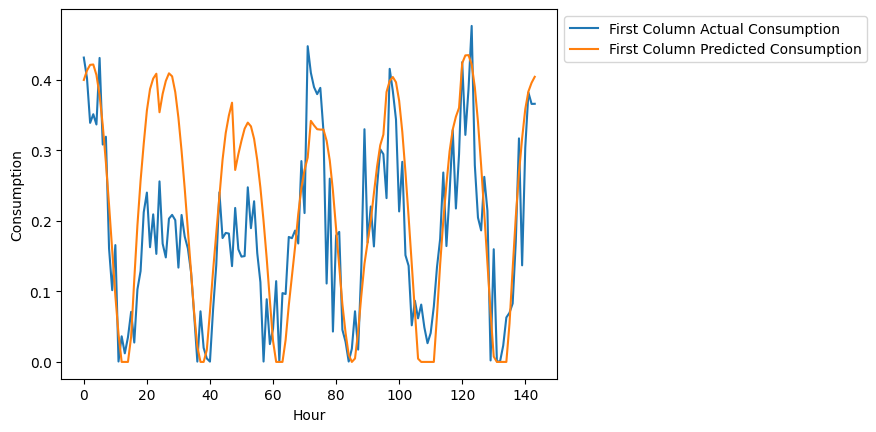

In [8]:
plot_predictions(0, 6, y_test, predicted)

Plot predictions for the last 7 days in the validation set

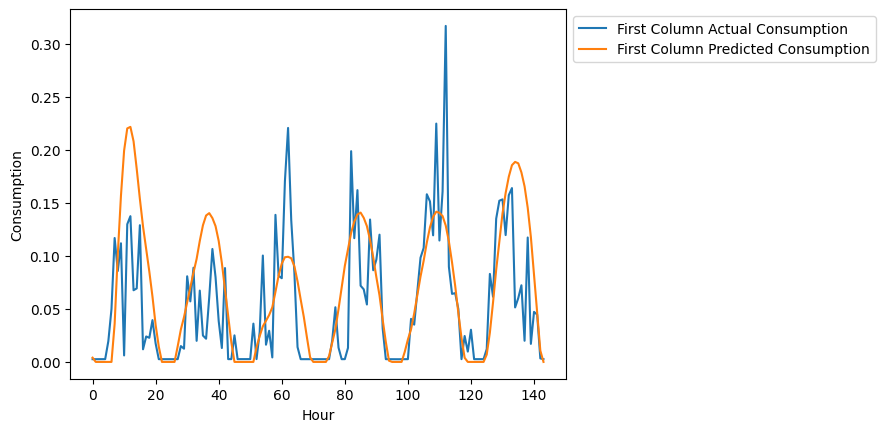

In [9]:
plot_predictions(-7, -1, y_test, predicted)

Plot predictions for 7 days in the in the middle of the validation set.

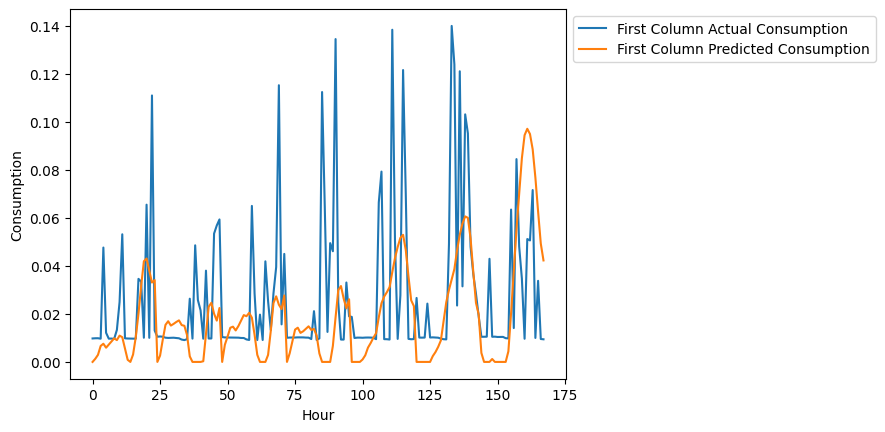

In [10]:
days_count = len(y_test) / 24
plot_predictions(int(days_count / 2), int(days_count / 2 + 7), y_test, predicted)